# ЛР №1 Проведение исследований с алгоритмом KNN.
Для классификации был выбрал датасет 'Loan new dataset' https://www.kaggle.com/datasets/willianoliveiragibin/financial-risk-v2 \
Задачей было определять, разрешат ли кредит клиенту - столбец LoanApproved (0 - не разрешено, 1 - разрешено) \
Для регрессии был выбран датасет 'medical_insurance' https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction \
Задачей было предсказывать цену страховки - столбец charges.

# Классификация
Сначала рассмотрим задачу классификации

Загружаем датасет и смотрим его верхние строки

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

file_path = "loan.csv"
data = pd.read_csv(file_path)
data.head()


,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.0,7.249.720.460.524.030,11,126928,19.965.200.000.000.000,22.758.963.035.547.000,4.198.059.915.607.370,18.107.719.782.539.400,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,33.090.833.333.333.300,9.351.320.992.549.320,3,43609,207.045,2.010.771.214.969.360,7.940.542.382.198.960,3.898.524.480.253.530,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,33.936.666.666.666.600,8.722.406.105.782.900,6,5205,21.762.700.000.000.000,21.254.800.984.525.700,6.664.066.876.774.690,4.621.569.652.325.320,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.0,8.961.547.069.636.460,5,99452,300.398,3.009.108.491.496.010,10.475.069.802.292.900,3.130.983.116.604.640,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8.605.333.333.333.330,9.413.687.393.229.140,5,227019,197.184,17.599.017.877.532.800,33.017.914.048.482.300,7.020.984.743.780.870,1,36.0


Посмотрим на распределение LoanApproved в датасете:

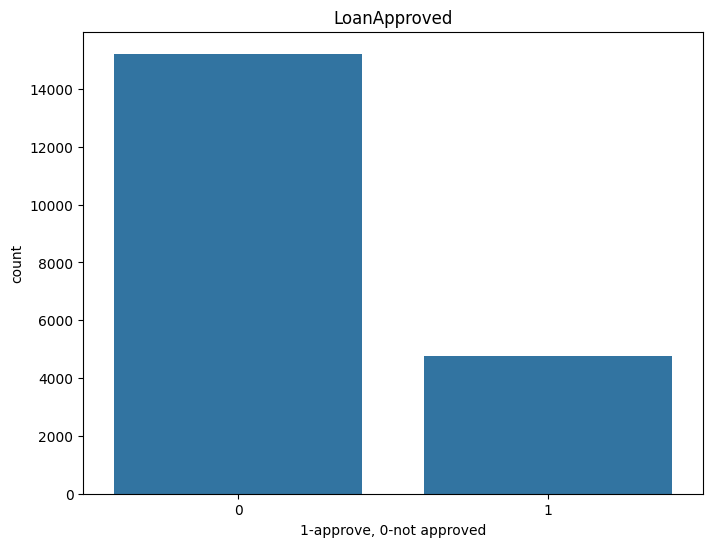

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='LoanApproved', data=data)
plt.title('LoanApproved')
plt.xlabel('1-approve, 0-not approved')
plt.ylabel('count')
plt.show()

Удалим ненужный столбец ApplicationDate, кодируем категориальные фичи и разделим фичи на целевые и не целевые

In [62]:
data_cleaned = data.drop(columns=['ApplicationDate'])

imputer = SimpleImputer(strategy='mean')
numerical_columns = data_cleaned.select_dtypes(include=['int64', 'float64']).columns
data_cleaned[numerical_columns] = imputer.fit_transform(data_cleaned[numerical_columns])

#кодирование категориальных фич

categorical_columns = data_cleaned.select_dtypes(include=['object']).columns
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data_cleaned[column] = le.fit_transform(data_cleaned[column].astype(str))
    label_encoders[column] = le

#разделение фич на целевую и не целевую
X = data_cleaned.drop(columns=['LoanApproved'])
y = data_cleaned['LoanApproved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Обучение KNN. В качестве метрики качества будем использовать accuracy

In [63]:
knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(X_train, y_train)

y_pred = knn_baseline.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)
baseline_report = classification_report(y_test, y_pred)

print("Accuracy:", baseline_accuracy)
print(baseline_report)


Accuracy: 0.95125
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      2983
         1.0       0.95      0.85      0.90      1017

    accuracy                           0.95      4000
   macro avg       0.95      0.92      0.93      4000
weighted avg       0.95      0.95      0.95      4000



Получаем достаточно высокие значения accuracy - 0.9512. Для класса одобрения кредита (1.0) recall ниже, поэтому это можно улучшить. \
Гипотеза - попробуем подобрать оптимальное число соседей (neighbors) - от 1 до 21 - и обучим модель заново. Число разбиений в кросс-валидации - 5

In [64]:
#поиск оптималного числа соседей
param_grid = {'n_neighbors': range(1, 21)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("best neighbors:", best_params)
print("best score:", best_score)

#обучим улучшенную модель, чтобы посмотреть, как улучшится или не улучшится accuracy
knn_optimized = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
knn_optimized.fit(X_train, y_train)
y_pred_optimized = knn_optimized.predict(X_test)
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
optimized_report = classification_report(y_test, y_pred_optimized)

print("optimized accuracy:", optimized_accuracy)
print(optimized_report)


best neighbors: {'n_neighbors': 17}
best score: 0.95225
optimized accuracy: 0.95525
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2983
         1.0       0.98      0.84      0.91      1017

    accuracy                           0.96      4000
   macro avg       0.96      0.92      0.94      4000
weighted avg       0.96      0.96      0.95      4000



In [65]:
print("base model accuracy:", baseline_accuracy)
print("optimised model accuracy:", optimized_accuracy)


base model accuracy: 0.95125
optimised model accuracy: 0.95525


Вывод - оптимизация засчет подобранного оптмального числа соседей улучшила точность модели с 0.95 до 0.96 - результат улучшился не сильно, но accuracy и так была достаточно высокой - поэтому добиться еще более хороших результатов трудно.

# Регрессия
Теперь перейдем к задаче регрессии. Импортируем датасет и посмотрим информацию о нем. Будем предсказывать charges

In [66]:
import pandas as pd

file_path = 'medical_insurance.csv'
data = pd.read_csv(file_path)


data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


(   age     sex     bmi  children smoker     region      charges
 0   19  female  27.900         0    yes  southwest  16884.92400
 1   18    male  33.770         1     no  southeast   1725.55230
 2   28    male  33.000         3     no  southeast   4449.46200
 3   33    male  22.705         0     no  northwest  21984.47061
 4   32    male  28.880         0     no  northwest   3866.85520,
 None)

Преобразуем категориальные признаки, чтобы избавиться от текстовых признаков:

In [67]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le


Разделим данные на целевые и не целевые, а так же разделим на тестовую и обучающую выборки

In [68]:
from sklearn.model_selection import train_test_split

X = data.drop('charges', axis=1)
y = data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Обучим базовую модель. В качестве метрик качества используем MSE и R^2 score.

In [69]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

baseline_model = KNeighborsRegressor()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R^2 score:", r2)

MSE: 91389788.20287144
R^2 score: 0.4045529172845289


Сформулируем гипотезы по улучшению результата: \
- Нормализация данных \
- Подбор гиперпараметров \

Нормализуем данные с помощью StandardScaler из sklearn, а так же попробуем подобрать гиперпараметры.

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#подбор гиперпараметров
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  #manhattan и евклидовые расстояния
}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

print("best params:", grid_search.best_params_)


best params: {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}


Получили лучшие параметры - число соседей 9, p - 2 (евклидово расстояние), веса - distance. \
Обучим модель с новыми параметрами:

In [71]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

y_pred_improved = best_model.predict(X_test_scaled)

mse_improved = mean_squared_error(y_test, y_pred_improved)
r2_improved = r2_score(y_test, y_pred_improved)

print("improved MSE:", mse_improved)
print("improved R^2 score:", r2_improved)


improved MSE: 6321886.3993354505
improved R^2 score: 0.9588099623845651


In [73]:
print("base MSE:", mse, "improved MSE:",mse_improved)
print("base R^2:", r2, "improved R^2:", r2_improved)


base MSE: 91389788.20287144 improved MSE: 6321886.3993354505
base R^2: 0.4045529172845289 improved R^2: 0.9588099623845651


Видно, что улучшения сильно улучшили показатели модели, например R^2 score стал почти в 2 раза больше. \
Построим график предсказанных и правильных значений, чтобы убедиться в точности модели:

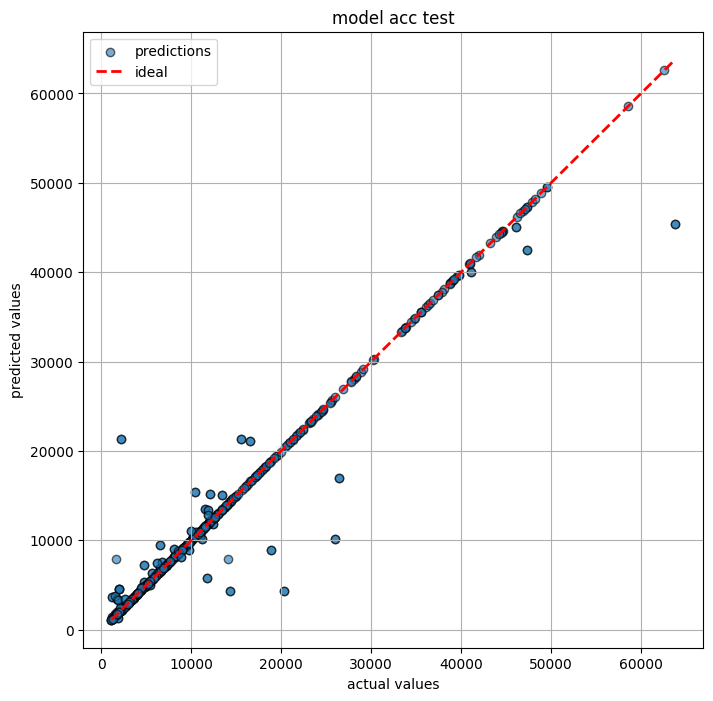

In [74]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_improved, alpha=0.6, edgecolor='k', label="predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="ideal")
plt.title("model acc test")
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.legend()
plt.grid(True)
plt.show()


По графику видно, что модель действительно очень точно предсказывает стоимость страховки. Почти все значения находятся на прямой идеальных предсказаний, или находятся в достаточной близости от нее.

# Самостоятельная имплементация регрессии

Определим класс регрессора со всеми необходимыми функциями:

In [75]:
import numpy as np

class KNNRegressor:
    def __init__(self, n_neighbors=5, p=2):
        self.n_neighbors = n_neighbors
        self.p = p

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def _distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2) ** self.p, axis=1) ** (1 / self.p)

    def _predict_one(self, x):
        distances = self._distance(self.X_train, x)
        neighbor_indices = distances.argsort()[:self.n_neighbors]
        neighbor_values = self.y_train[neighbor_indices]
        return neighbor_values.mean()

    def predict(self, X):
        return np.array([self._predict_one(x) for x in X])


Обучим модель на введенных ранее данных и посмотрим на полученные значения MSE и R^2 score. Число соседей оставим 5, метрика расстояния - Евклидово.

In [77]:
knn_model = KNNRegressor(n_neighbors=5, p=2)
knn_model.fit(X_train_scaled, y_train)

y_pred_custom = knn_model.predict(X_test_scaled)

custom_mse = mean_squared_error(y_test, y_pred_custom)
custom_r2 = r2_score(y_test, y_pred_custom)

print("custom MSE:", custom_mse)
print("custom R^2 score:", custom_r2)


custom MSE: 24244373.760919515
custom R^2 score: 0.8420366004552196


In [78]:
print("base MSE:", mse, "custom MSE:", custom_mse)
print("base R^2:", r2, "custom R^2:", custom_r2)


base MSE: 91389788.20287144 custom MSE: 24244373.760919515
base R^2: 0.4045529172845289 custom R^2: 0.8420366004552196


По метрикам видно, что кастомная модель работает лучше, чем базовая (MSE:
25018209.67 < 89729299.02)

Гипотеза - подберем оптимальные гиперпараметры, которые позволят улучшить точность модели. Выбирать будем из разных комбинаций метрик расстояния и числа соседей.

In [79]:
best_mse = float('inf')
best_params = None

for n_neighbors in [3, 5, 7, 9]:
    for p in [1, 2]:
        knn_model = KNNRegressor(n_neighbors=n_neighbors, p=p)
        knn_model.fit(X_train_scaled, y_train)
        y_pred_custom = knn_model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred_custom)
        if mse < best_mse:
            best_mse = mse
            best_params = {'n_neighbors': n_neighbors, 'p': p}

print("best params:", best_params)
print("best MSE:", best_mse)


best params: {'n_neighbors': 3, 'p': 2}
best MSE: 20927863.246673156


Теперь обучим модель с новыми гиперпараметрами:

In [80]:
knn_model = KNNRegressor(n_neighbors=best_params['n_neighbors'], p=best_params['p'])
knn_model.fit(X_train_scaled, y_train)

y_pred_custom_improved = knn_model.predict(X_test_scaled)
improved_custom_mse = mean_squared_error(y_test, y_pred_custom_improved)
improved_custom_r2 = r2_score(y_test, y_pred_custom_improved)

print("improved custom MSE:",improved_custom_mse)
print("improved custom R^2 score:",improved_custom_r2)


improved custom MSE: 20927863.246673156
improved custom R^2 score: 0.8636452128542265


In [81]:
print("base MSE:", mse, ", improved base MSE:", mse_improved, ", improved custom MSE:", improved_custom_mse)
print("base R^2:", r2, ", improved base R^2:", r2_improved, ", improved custom R^2:", improved_custom_r2)


base MSE: 26099050.053674247 , improved base MSE: 6321886.3993354505 , improved custom MSE: 20927863.246673156
base R^2: 0.4045529172845289 , improved base R^2: 0.9588099623845651 , improved custom R^2: 0.8636452128542265


Видно, что наилучший результат показывает оптимизарованная библиотечная модель.
Построим график, чтобы наглядно сравнить кастомную реализацию с библиотечной

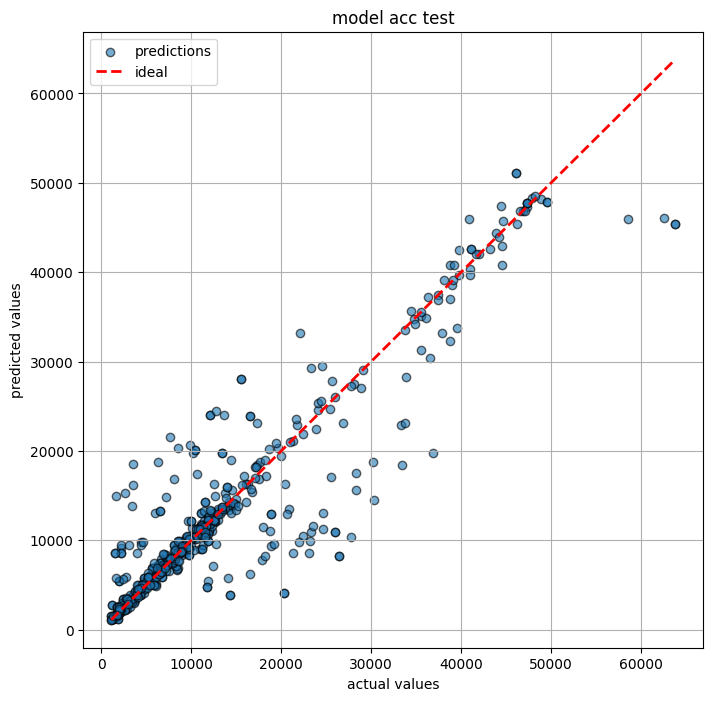

In [82]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_custom_improved, alpha=0.6, edgecolor='k', label="predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="ideal")
plt.title("model acc test")
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.legend()
plt.grid(True)
plt.show()

### Выводы:
- Улучшенная собственная модель KNN показывает лучшие результаты по сравнению с базовой по метрике MSE, однако проигрывает базовой по R^2
- Гиперпараметры (например, число соседей и выбранная метрика расстояния) значительно влияют на качество модели

Можно сделать вывод, что бейзлайн модель показывает все же более лучший результат (что подтверждается графиком выше)


# Самостоятельная имплементация классификации:

Перейдем к самостоятельной имплементации классификации. Импортируем данные из датасета:

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

file_path = "loan.csv"
data = pd.read_csv(file_path)
data = data.sample(n=1000, random_state=42)


print(data.head())
print(data.info())


      ApplicationDate  Age  AnnualIncome  CreditScore EmploymentStatus  \
10650      2047-02-28   37        100761          604         Employed   
2041       2023-08-04   35        189154          509         Employed   
8668       2041-09-25   44         73272          483         Employed   
1114       2021-01-19   41         57115          412         Employed   
13902      2056-01-24   39         61155          551         Employed   

      EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  ...  \
10650    High School          16       28479            84        Single  ...   
2041     High School          11       11222            60       Married  ...   
8668     High School          20       31573            48       Widowed  ...   
1114          Master          20       21937            12       Married  ...   
13902         Master          19       31510            48      Divorced  ...   

                MonthlyIncome UtilityBillsPaymentHistory  JobTenure 

Преобразуем категориальные признаки, разделим выборки на обучающую и тестовую:

In [84]:
data = pd.get_dummies(data, drop_first=True)

X = data.drop("LoanApproved", axis=1)
y = data["LoanApproved"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

Определим кастомный классификатор

In [85]:
import numpy as np
from collections import Counter

class CustomKNNClassifier:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            neighbor_indices = np.argsort(distances)[:self.n_neighbors]
            neighbor_labels = self.y_train[neighbor_indices]
            most_common = Counter(neighbor_labels).most_common(1)
            predictions.append(most_common[0][0])
        return np.array(predictions)

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == np.array(y))
    def get_params(self, deep=True):
        return {'n_neighbors': self.n_neighbors}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self



Обучим кастомную модель, выведем результаты в консоль (будем ориентироваться на метрику accuracy)

In [86]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = CustomKNNClassifier(5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.6


Нормализация, поиск оптимальных параметров и обучение

In [38]:
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
#norm
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
#поиск оптималного числа соседей
param_grid = {'n_neighbors': [3,5,6,7]}
grid_search = GridSearchCV(CustomKNNClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("best neighbors:", best_params)
print("best score:", best_score)

#обучим улучшенную модель, чтобы посмотреть, как улучшится или не улучшится accuracy
knn_optimized = CustomKNNClassifier(n_neighbors=best_params['n_neighbors'])
knn_optimized.fit(X_train, y_train)
y_pred_optimized = knn_optimized.predict(X_test)
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)

print("optimized accuracy:", optimized_accuracy)

best neighbors: {'n_neighbors': 3}
best score: 0.7373737373737375
optimized accuracy: 0.6


Можно сделать вывод, что кастомный классификатор справляется хуже, чем бейзлайн. Это может быть связано с уменьшенным размером датасета (что было сделано исходя из hardware-ных ограничений).